In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div style="display:block;width:100%;margin:auto;" direction=rtl align=center><br><br>
    <div  style="width:100%;margin:100;display:block;background-color:#fff0;"  display=block align=center>
        <table style="border-style:hidden;border-collapse:collapse;">             <tr>
                <td  style="border: none!important;">
                    <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>Armin Ghasemi</b><br><br>810100198</i></font></h1>
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>deep learning </b><br><br>HW_2 Q1</i></font></h1>
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>Amirhossein samoudi </b><br><br>810100108</i></font></h1>
                </td>
                <td style="border: none!important;">
                    <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
                </td>
           </tr>
        </table>
    </div>
</div>


### imports

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense,
    Activation, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.optimizers import Adam
import albumentations as A
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import shutil
from tqdm import tqdm
import cv2
import glob
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense , Lambda , GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, MobileNetV2


### part1 : Dataset analysis

####  Check image format and specifications

In [ ]:
base_path = Path("/content/drive/My Drive/Data")
splits = ["train", "test"]
classes = ["COVID19", "NORMAL", "PNEUMONIA"]

data_count = []
sample_info = []

for split in splits:
    for cls in classes:
        folder = base_path / split / cls
        images = list(folder.glob("*"))
        data_count.append({
            "Split": split,
            "Class": cls,
            "Count": len(images)
        })

        for img_path in images[:3]:
            try:
                with Image.open(img_path) as img:
                    sample_info.append({
                        "Split": split,
                        "Class": cls,
                        "Filename": img_path.name,
                        "Format": img.format,
                        "Size": img.size,
                        "Mode": img.mode
                    })
            except Exception as e:
                sample_info.append({
                    "Split": split,
                    "Class": cls,
                    "Filename": img_path.name,
                    "Error": str(e)
                })

sample_df = pd.DataFrame(sample_info)
sample_df


,Split,Class,Filename,Format,Size,Mode
0,train,COVID19,COVID19(110).jpg,JPEG,"(1036, 885)",RGB
1,train,COVID19,COVID19(114).jpg,JPEG,"(1696, 1403)",RGB
2,train,COVID19,COVID19(10).jpg,JPEG,"(1038, 1031)",RGB
3,train,NORMAL,NORMAL(1252).jpg,JPEG,"(1370, 1079)",RGB
4,train,NORMAL,NORMAL(1260).jpg,JPEG,"(1959, 1920)",RGB
5,train,NORMAL,NORMAL(1244).jpg,JPEG,"(1546, 1294)",RGB
6,train,PNEUMONIA,PNEUMONIA(3099).jpg,JPEG,"(1024, 696)",RGB
7,train,PNEUMONIA,PNEUMONIA(3087).jpg,JPEG,"(667, 322)",RGB
8,train,PNEUMONIA,PNEUMONIA(3126).jpg,JPEG,"(1345, 902)",RGB
9,test,COVID19,COVID19(460).jpg,PNG,"(2496, 1969)",RGB


#### Plot class distribution

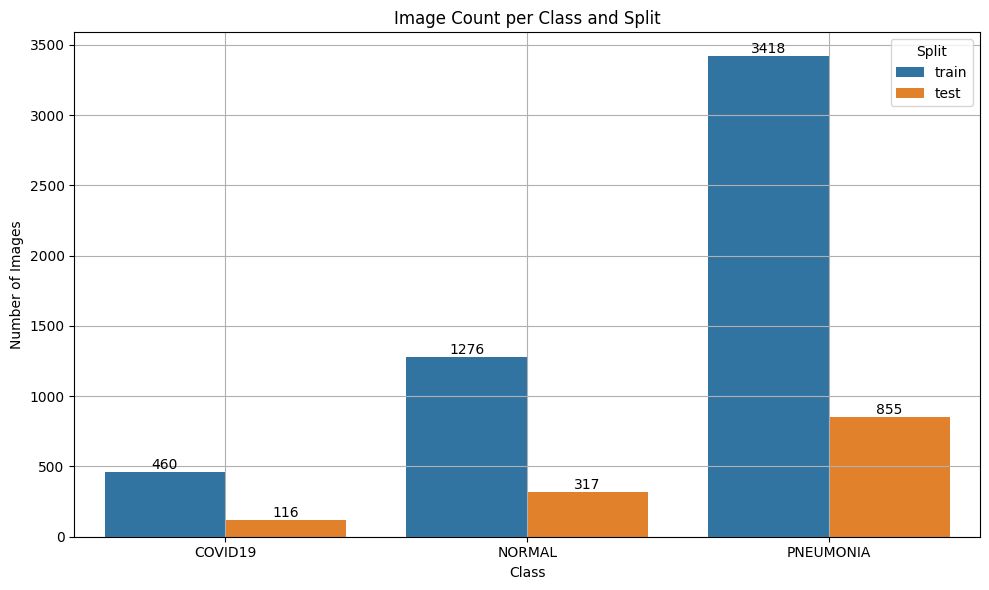

In [ ]:
df = pd.DataFrame(data_count)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Class", y="Count", hue="Split", data=df)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

plt.title("Image Count per Class and Split")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.grid(True)
plt.tight_layout()
plt.show()

### part2 : Data preprocessing

#### Downsampling and Plot class distribution in balance data

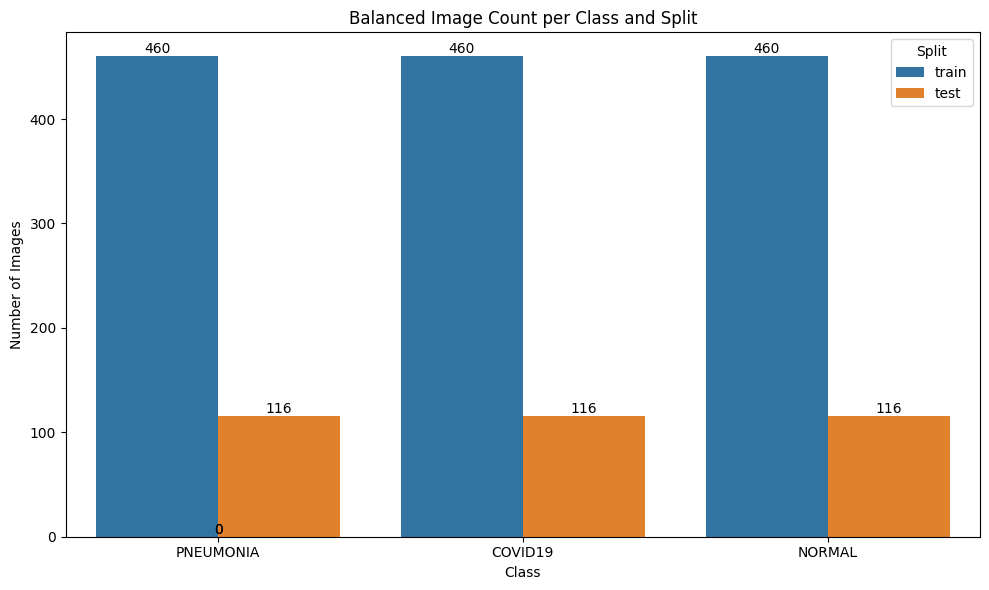

In [ ]:
random.seed(42)

original_data_dir = "/content/drive/My Drive/Data"
balanced_data_dir = "/content/drive/My Drive/Output/balanced_data"

splits = ['train', 'test']
class_counts = defaultdict(lambda: defaultdict(int))
file_paths = defaultdict(lambda: defaultdict(list))

for split in splits:
    split_path = os.path.join(original_data_dir, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(class_path, fname)
                class_counts[split][class_name] += 1
                file_paths[split][class_name].append(file_path)

min_samples = {
    split: min(class_counts[split].values())
    for split in splits
}

for split in splits:
    for class_name, files in file_paths[split].items():
        sampled_files = random.sample(files, min_samples[split])
        dest_dir = os.path.join(balanced_data_dir, split, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        for src_path in sampled_files:
            shutil.copy(src_path, dest_dir)

balanced_counts = []
for split in splits:
    for class_name in os.listdir(os.path.join(balanced_data_dir, split)):
        count = len(os.listdir(os.path.join(balanced_data_dir, split, class_name)))
        balanced_counts.append({
            'Class': class_name,
            'Split': split,
            'Count': count
        })

df_balanced = pd.DataFrame(balanced_counts)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_balanced, x="Class", y="Count", hue="Split")

for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.title("Balanced Image Count per Class and Split")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

#### data augmentation

In [ ]:

input_base = "/content/drive/My Drive/Output/balanced_data"
output_base = "/content/drive/My Drive/Output/augmented_data"
sets = ["train", "test"]
classes = ["COVID19", "NORMAL", "PNEUMONIA"]

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.1),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=0, p=0.5),
])

for s in sets:
    for cls in classes:
        os.makedirs(os.path.join(output_base, s, cls), exist_ok=True)

corrupted_files = []

for s in sets:
    for cls in classes:
        input_dir = os.path.join(input_base, s, cls)
        output_dir = os.path.join(output_base, s, cls)

        filenames = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        print(f"Augmenting {s}/{cls}...")
        for filename in tqdm(filenames):
            input_path = os.path.join(input_dir, filename)
            image = cv2.imread(input_path)

            if image is None:
                corrupted_files.append(os.path.join(s, cls, filename))
                continue

            for i in range(6):
                augmented = transform(image=image)
                aug_img = augmented['image']
                new_filename = f"{os.path.splitext(filename)[0]}_aug{i}.jpg"
                output_path = os.path.join(output_dir, new_filename)
                cv2.imwrite(output_path, aug_img)

with open("/content/drive/My Drive/Output/corrupted_files.txt", "w") as f:
    for item in corrupted_files:
        f.write(item + "\n")

print(f"Corrupted files: {len(corrupted_files)} (saved to corrupted_files.txt)")

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Augmenting train/COVID19...


100%|██████████| 460/460 [03:02<00:00,  2.52it/s]


Augmenting train/NORMAL...


100%|██████████| 460/460 [02:55<00:00,  2.62it/s]


Augmenting train/PNEUMONIA...


100%|██████████| 460/460 [01:34<00:00,  4.88it/s]


Augmenting test/COVID19...


100%|██████████| 116/116 [00:57<00:00,  2.01it/s]


Augmenting test/NORMAL...


100%|██████████| 116/116 [00:44<00:00,  2.60it/s]


Augmenting test/PNEUMONIA...


100%|██████████| 116/116 [00:20<00:00,  5.64it/s]

Corrupted files: 0 (saved to corrupted_files.txt)


In [ ]:
sample_output_dir = "/content/drive/My Drive/Output/sample_augment"
os.makedirs(sample_output_dir, exist_ok=True)

train_class = random.choice(classes)
class_dir = os.path.join(output_base, "train", train_class)
augmented_files = glob.glob(os.path.join(class_dir, "*.jpg"))

base_names = list(set(f.split("_aug")[0] for f in augmented_files))
selected_base = random.choice(base_names)

selected_augmented = sorted([f for f in augmented_files if f.startswith(selected_base)])[:6]

original_image_path = None
for ext in ['.jpg', '.jpeg', '.png']:
    candidate = selected_base + ext
    path = os.path.join(input_base, "train", train_class, os.path.basename(candidate))
    if os.path.exists(path):
        original_image_path = path
        break

sample_dir = os.path.join(sample_output_dir, train_class + "_" + os.path.basename(selected_base))
os.makedirs(sample_dir, exist_ok=True)

if original_image_path:
    shutil.copy(original_image_path, os.path.join(sample_dir, "original.jpg"))

for i, filepath in enumerate(selected_augmented):
    dst_path = os.path.join(sample_dir, f"augmented_{i}.jpg")
    shutil.copy(filepath, dst_path)

### part3 : Model preparation

#### Create the CNN model

In [ ]:
def build_main_cnn(input_shape=(150, 150, 3)):
  model = Sequential()

  # 1st Conv Block
  model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
  model.add(BatchNormalization(axis=-1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  # 2nd Conv Block
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  # 3rd Conv Block
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  # 4th Conv Block
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  # 5th Conv Block
  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  # 6th Conv Block
  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  # Flatten and Dense Layers
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(3, activation='softmax'))

  return model


In [ ]:
model = build_main_cnn((150, 150, 3))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,805,891 (6.89 MB)

 Trainable params: 1,804,099 (6.88 MB)

 Non-trainable params: 1,792 (7.00 KB)

### part4 : Model training and evaluation

#### training

In [ ]:
# Hyperparameters
batch_size = 32
epochs = 30
initial_lr = 0.001
img_size = (150, 150)
input_shape = img_size + (3,)

# Paths
train_dir = '/content/drive/My Drive/Output/augmented_data/train'
test_dir = '/content/drive/My Drive/Output/augmented_data/test'

# Image preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.35,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 5385 images belonging to 3 classes.
Found 2895 images belonging to 3 classes.
Found 2088 images belonging to 3 classes.


In [ ]:
# Compile model
optimizer = Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_path = "/content/drive/My Drive/best_model_1.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

callbacks = [checkpoint, lr_scheduler, early_stopping]

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6757 - loss: 0.8977 
Epoch 1: val_accuracy improved from -inf to 0.33679, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 4216s 24s/step - accuracy: 0.6764 - loss: 0.8957 - val_accuracy: 0.3368 - val_loss: 2.6343 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.8986 - loss: 0.2777
Epoch 2: val_accuracy improved from 0.33679 to 0.53264, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.8986 - loss: 0.2776 - val_accuracy: 0.5326 - val_loss: 2.3414 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9137 - loss: 0.2329
Epoch 3: val_accuracy improved from 0.53264 to 0.88221, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9137 - loss: 0.2328 - val_accuracy: 0.8822 - val_loss: 0.3167 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.9222 - loss: 0.2106
Epoch 4: val_accuracy improved from 0.88221 to 0.89775, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9223 - loss: 0.2105 - val_accuracy: 0.8978 - val_loss: 0.2636 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.9220 - loss: 0.2064
Epoch 5: val_accuracy did not improve from 0.89775
169/169 ━━━━━━━━━━━━━━━━━━━━ 168s 995ms/step - accuracy: 0.9220 - loss: 0.2063 - val_accuracy: 0.7264 - val_loss: 0.9124 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9316 - loss: 0.1848
Epoch 6: val_accuracy did not improve from 0.89775
169/169 ━━━━━━━━━━━━━━━━━━━━ 167s 989ms/step - accuracy: 0.9316 - loss: 0.1848 - val_accuracy: 0.8884 - val_loss: 0.2867 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.9485 - loss: 0.1406
Epoch 7: val_accuracy did not improve from 0.89775

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9484 - loss: 0.140

169/169 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9536 - loss: 0.1144 - val_accuracy: 0.9503 - val_loss: 0.1409 - learning_rate: 5.0000e-04
Epoch 10/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.9641 - loss: 0.0925
Epoch 10: val_accuracy did not improve from 0.95026
169/169 ━━━━━━━━━━━━━━━━━━━━ 167s 990ms/step - accuracy: 0.9640 - loss: 0.0925 - val_accuracy: 0.8953 - val_loss: 0.2564 - learning_rate: 5.0000e-04
Epoch 11/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9660 - loss: 0.0900
Epoch 11: val_accuracy did not improve from 0.95026
169/169 ━━━━━━━━━━━━━━━━━━━━ 166s 987ms/step - accuracy: 0.9660 - loss: 0.0900 - val_accuracy: 0.9458 - val_loss: 0.1450 - learning_rate: 5.0000e-04
Epoch 12/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.9671 - loss: 0.0886
Epoch 12: val_accuracy did not improve from 0.95026

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
169/169 ━━━━━━━━━━━━━━━━━━━━ 165s 980ms/step - accuracy

#### Plot training & validation accuracy values

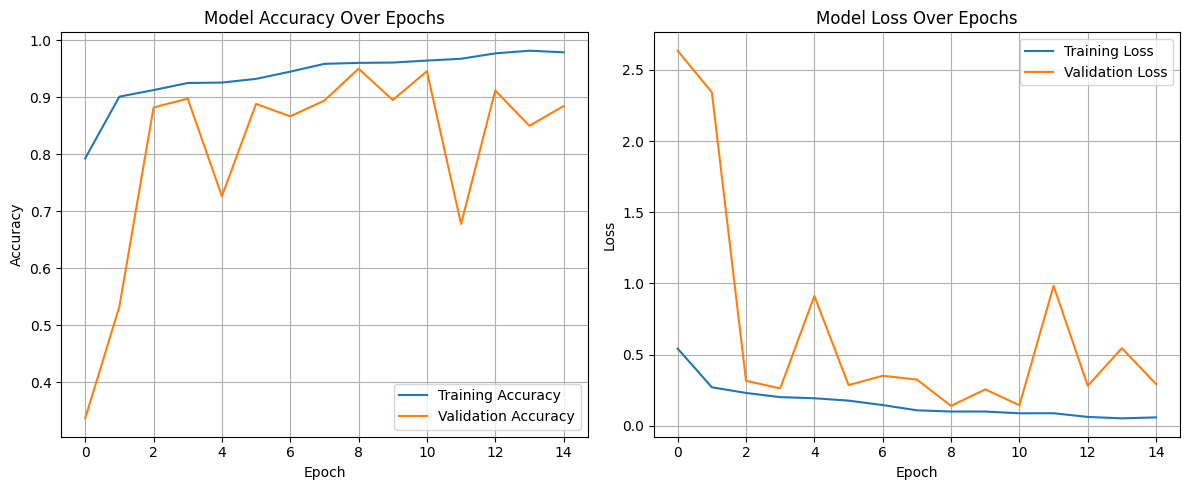

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

#### evaluation

66/66 ━━━━━━━━━━━━━━━━━━━━ 1488s 23s/step
Classification Report:

              precision    recall  f1-score   support

     COVID19       0.99      0.98      0.98       696
      NORMAL       0.92      0.93      0.93       696
   PNEUMONIA       0.92      0.92      0.92       696

    accuracy                           0.94      2088
   macro avg       0.94      0.94      0.94      2088
weighted avg       0.94      0.94      0.94      2088



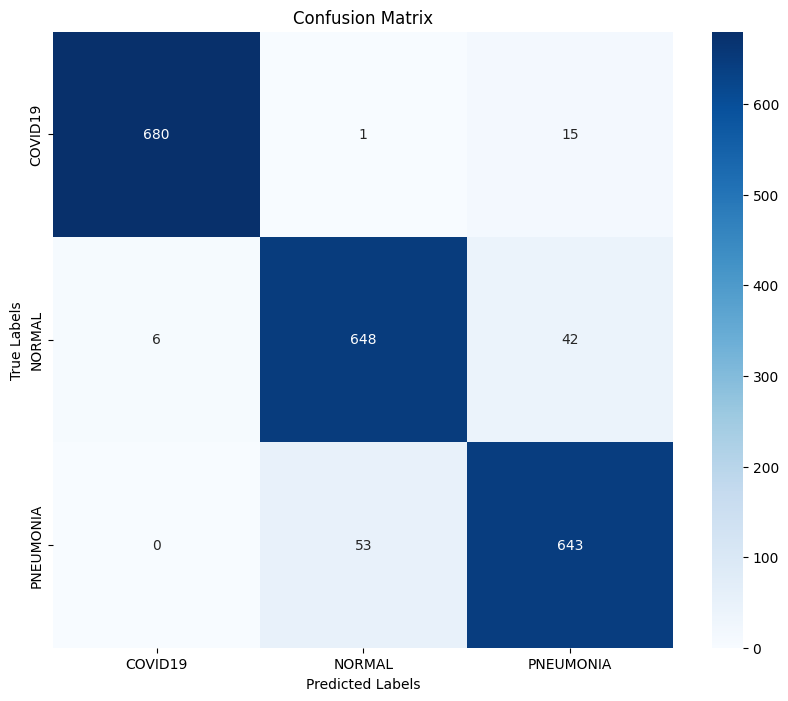

In [ ]:
model = load_model('/content/drive/My Drive/best_model_1.h5')

Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### part5 : transfer learning

In [4]:
# Hyperparameters
batch_size = 32
epochs = 100
initial_lr = 0.001
img_size = (150, 150)
input_shape = img_size + (3,)

# Paths
train_dir = '/content/drive/My Drive/Output/augmented_data/train'
test_dir = '/content/drive/My Drive/Output/augmented_data/test'

# Image preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.35,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 5385 images belonging to 3 classes.
Found 2895 images belonging to 3 classes.
Found 2088 images belonging to 3 classes.


#### VGG

In [ ]:
base_model_choice = 'vgg16'  # 'vgg16' or 'mobilenetv2'

if base_model_choice == 'vgg16':
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
elif base_model_choice == 'mobilenetv2':
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
else:
    raise ValueError("Unsupported model choice. Use 'vgg16' or 'mobilenetv2'.")

# Freeze the base model
base_model.trainable = False

# Build model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

In [ ]:
# Compile model
optimizer = Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_path = "/content/drive/My Drive/best_model_1.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

callbacks = [checkpoint, lr_scheduler, early_stopping]

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5919 - loss: 0.8543
Epoch 1: val_accuracy improved from -inf to 0.86667, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 753s 4s/step - accuracy: 0.5926 - loss: 0.8531 - val_accuracy: 0.8667 - val_loss: 0.3694 - learning_rate: 0.0010
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.8435 - loss: 0.3991
Epoch 2: val_accuracy improved from 0.86667 to 0.88946, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.8435 - loss: 0.3990 - val_accuracy: 0.8895 - val_loss: 0.2966 - learning_rate: 0.0010
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.8716 - loss: 0.3270
Epoch 3: val_accuracy improved from 0.88946 to 0.90363, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.8716 - loss: 0.3269 - val_accuracy: 0.9036 - val_loss: 0.2489 - learning_rate: 0.0010
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.8859 - loss: 0.2940
Epoch 4: val_accuracy improved from 0.90363 to 0.90743, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.8860 - loss: 0.2939 - val_accuracy: 0.9074 - val_loss: 0.2497 - learning_rate: 0.0010
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.8950 - loss: 0.2820
Epoch 5: val_accuracy did not improve from 0.90743
169/169 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8951 - loss: 0.2818 - val_accuracy: 0.9019 - val_loss: 0.2396 - learning_rate: 0.0010
Epoch 6/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.9073 - loss: 0.2364
Epoch 6: val_accuracy did not improve from 0.90743
169/169 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9073 - loss: 0.2365 - val_accuracy: 0.8808 - val_loss: 0.2749 - learning_rate: 0.0010
Epoch 7/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.9171 - loss: 0.2219
Epoch 7: val_accuracy improved from 0.90743 to 0.92021, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9170 - loss: 0.2220 - val_accuracy: 0.9202 - val_loss: 0.2054 - learning_rate: 0.0010
Epoch 8/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.9116 - loss: 0.2330
Epoch 8: val_accuracy improved from 0.92021 to 0.92608, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9116 - loss: 0.2330 - val_accuracy: 0.9261 - val_loss: 0.1963 - learning_rate: 0.0010
Epoch 9/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.9221 - loss: 0.2192
Epoch 9: val_accuracy improved from 0.92608 to 0.93368, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9221 - loss: 0.2192 - val_accuracy: 0.9337 - val_loss: 0.1959 - learning_rate: 0.0010
Epoch 10/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.9181 - loss: 0.2162
Epoch 10: val_accuracy did not improve from 0.93368
169/169 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9181 - loss: 0.2162 - val_accuracy: 0.9209 - val_loss: 0.2045 - learning_rate: 0.0010
Epoch 11/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9273 - loss: 0.1982
Epoch 11: val_accuracy did not improve from 0.93368
169/169 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9273 - loss: 0.1983 - val_accuracy: 0.9209 - val_loss: 0.2280 - learning_rate: 0.0010
Epoch 12/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9182 - loss: 0.2196
Epoch 12: val_accuracy did not improve from 0.93368

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9182 - loss: 0

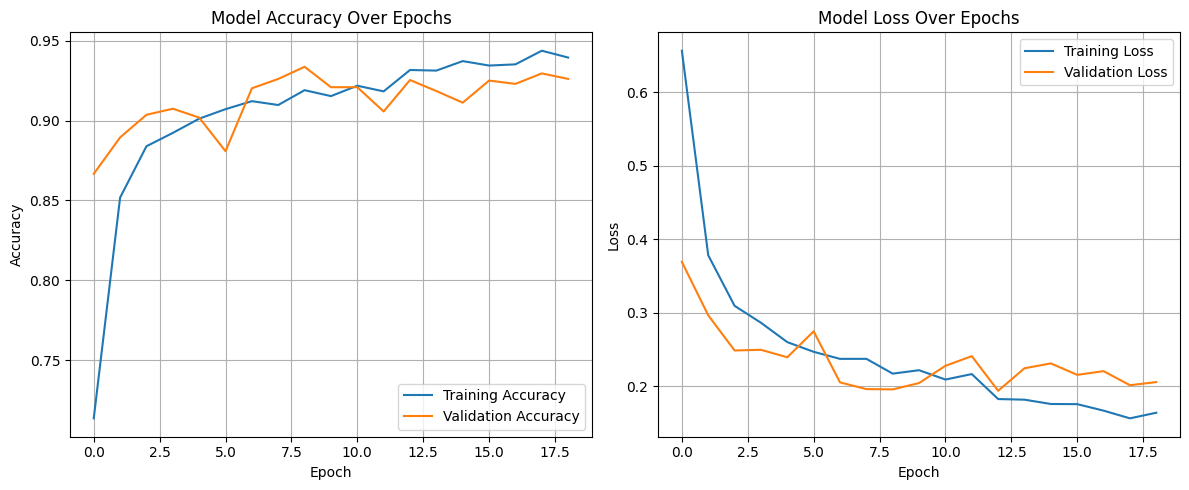

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

66/66 ━━━━━━━━━━━━━━━━━━━━ 549s 8s/step
Classification Report:

              precision    recall  f1-score   support

     COVID19       0.98      0.97      0.97       696
      NORMAL       0.84      0.97      0.90       696
   PNEUMONIA       0.94      0.81      0.87       696

    accuracy                           0.92      2088
   macro avg       0.92      0.92      0.91      2088
weighted avg       0.92      0.92      0.91      2088



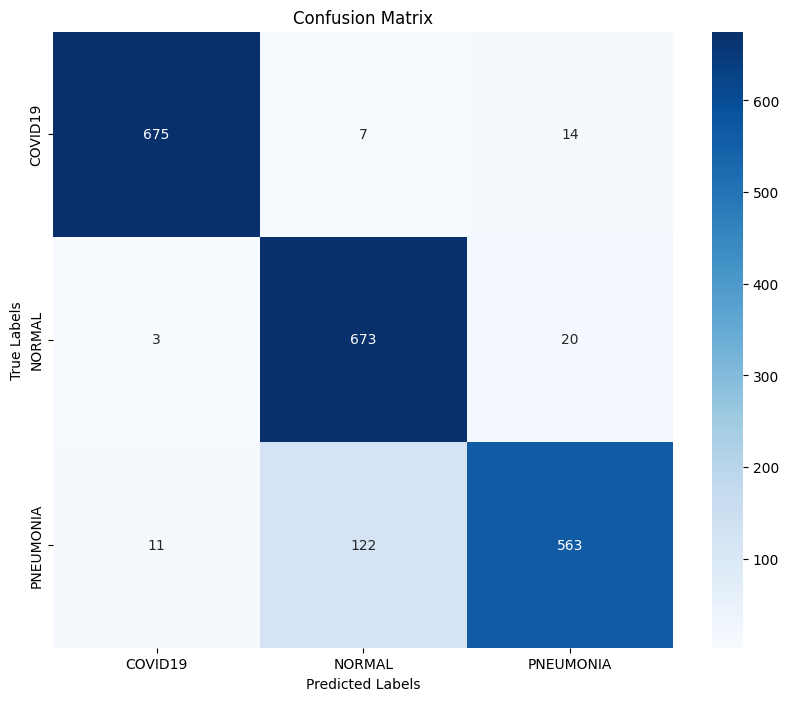

In [ ]:
# Load the best model
model = load_model('/content/drive/My Drive/best_model_1.h5')

# Evaluate on Test Set
Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### MobileNet

In [5]:
base_model_choice = 'mobilenetv2'  # 'vgg16' or 'mobilenetv2'

if base_model_choice == 'vgg16':
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
elif base_model_choice == 'mobilenetv2':
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
else:
    raise ValueError("Unsupported model choice. Use 'vgg16' or 'mobilenetv2'.")

# Freeze the base model
base_model.trainable = False

# Build model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

<ipython-input-5-3d90185d3593>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
# Compile model
optimizer = Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_path = "/content/drive/My Drive/best_model_1.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

callbacks = [checkpoint, lr_scheduler, early_stopping]

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7208 - loss: 0.6341 
Epoch 1: val_accuracy improved from -inf to 0.88981, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 4125s 24s/step - accuracy: 0.7213 - loss: 0.6330 - val_accuracy: 0.8898 - val_loss: 0.2754 - learning_rate: 0.0010
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.8850 - loss: 0.3109
Epoch 2: val_accuracy improved from 0.88981 to 0.89672, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.8850 - loss: 0.3109 - val_accuracy: 0.8967 - val_loss: 0.2503 - learning_rate: 0.0010
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.8959 - loss: 0.2823
Epoch 3: val_accuracy improved from 0.89672 to 0.92504, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.8960 - loss: 0.2822 - val_accuracy: 0.9250 - val_loss: 0.2004 - learning_rate: 0.0010
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.9025 - loss: 0.2456
Epoch 4: val_accuracy improved from 0.92504 to 0.92781, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9026 - loss: 0.2456 - val_accuracy: 0.9278 - val_loss: 0.1879 - learning_rate: 0.0010
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.9176 - loss: 0.2184
Epoch 5: val_accuracy did not improve from 0.92781
169/169 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9176 - loss: 0.2184 - val_accuracy: 0.9233 - val_loss: 0.2110 - learning_rate: 0.0010
Epoch 6/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.9182 - loss: 0.2159
Epoch 6: val_accuracy improved from 0.92781 to 0.92953, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9182 - loss: 0.2158 - val_accuracy: 0.9295 - val_loss: 0.1841 - learning_rate: 0.0010
Epoch 7/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.9257 - loss: 0.1986
Epoch 7: val_accuracy improved from 0.92953 to 0.93299, saving model to /content/drive/My Drive/best_model_1.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9257 - loss: 0.1986 - val_accuracy: 0.9330 - val_loss: 0.1805 - learning_rate: 0.0010
Epoch 8/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.9265 - loss: 0.1953
Epoch 8: val_accuracy did not improve from 0.93299
169/169 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9265 - loss: 0.1953 - val_accuracy: 0.9275 - val_loss: 0.1970 - learning_rate: 0.0010
Epoch 9/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.9246 - loss: 0.1985
Epoch 9: val_accuracy did not improve from 0.93299
169/169 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9246 - loss: 0.1985 - val_accuracy: 0.9326 - val_loss: 0.1847 - learning_rate: 0.0010
Epoch 10/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9128 - loss: 0.2138
Epoch 10: val_accuracy did not improve from 0.93299

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9129 - loss: 0.213

169/169 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9409 - loss: 0.1594 - val_accuracy: 0.9385 - val_loss: 0.1756 - learning_rate: 5.0000e-04
Epoch 13/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9460 - loss: 0.1424
Epoch 13: val_accuracy did not improve from 0.93851
169/169 ━━━━━━━━━━━━━━━━━━━━ 167s 990ms/step - accuracy: 0.9460 - loss: 0.1424 - val_accuracy: 0.9385 - val_loss: 0.1622 - learning_rate: 5.0000e-04
Epoch 14/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9429 - loss: 0.1443
Epoch 14: val_accuracy did not improve from 0.93851
169/169 ━━━━━━━━━━━━━━━━━━━━ 166s 987ms/step - accuracy: 0.9429 - loss: 0.1443 - val_accuracy: 0.9354 - val_loss: 0.1796 - learning_rate: 5.0000e-04
Epoch 15/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9381 - loss: 0.1466
Epoch 15: val_accuracy did not improve from 0.93851
169/169 ━━━━━━━━━━━━━━━━━━━━ 167s 989ms/step - accuracy: 0.9381 - loss: 0.1466 - val_accuracy: 0.9382 - val_loss: 0.1682 - learnin

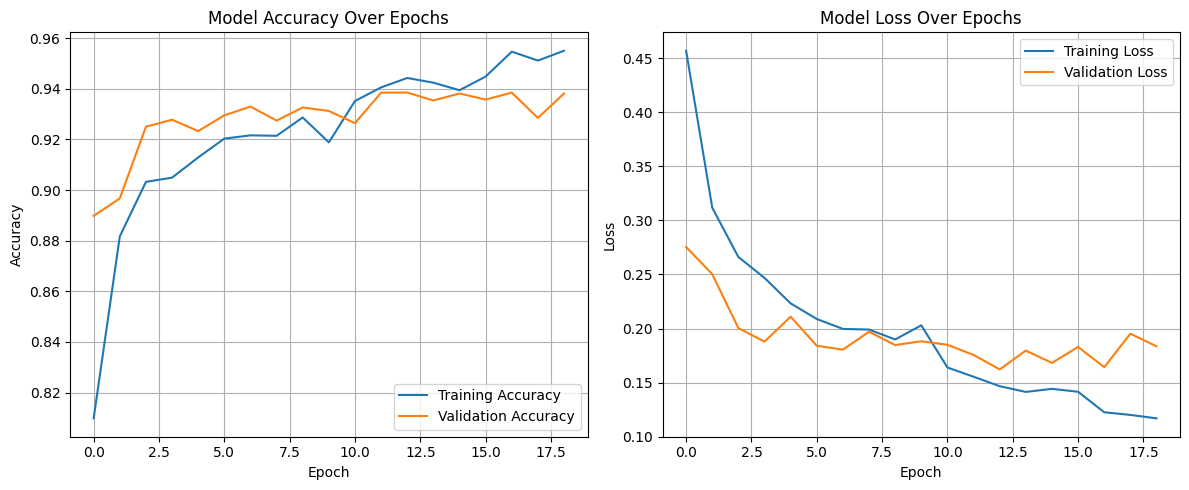

In [7]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

66/66 ━━━━━━━━━━━━━━━━━━━━ 1483s 23s/step
Classification Report:

              precision    recall  f1-score   support

     COVID19       0.99      0.94      0.97       696
      NORMAL       0.87      0.92      0.89       696
   PNEUMONIA       0.90      0.90      0.90       696

    accuracy                           0.92      2088
   macro avg       0.92      0.92      0.92      2088
weighted avg       0.92      0.92      0.92      2088



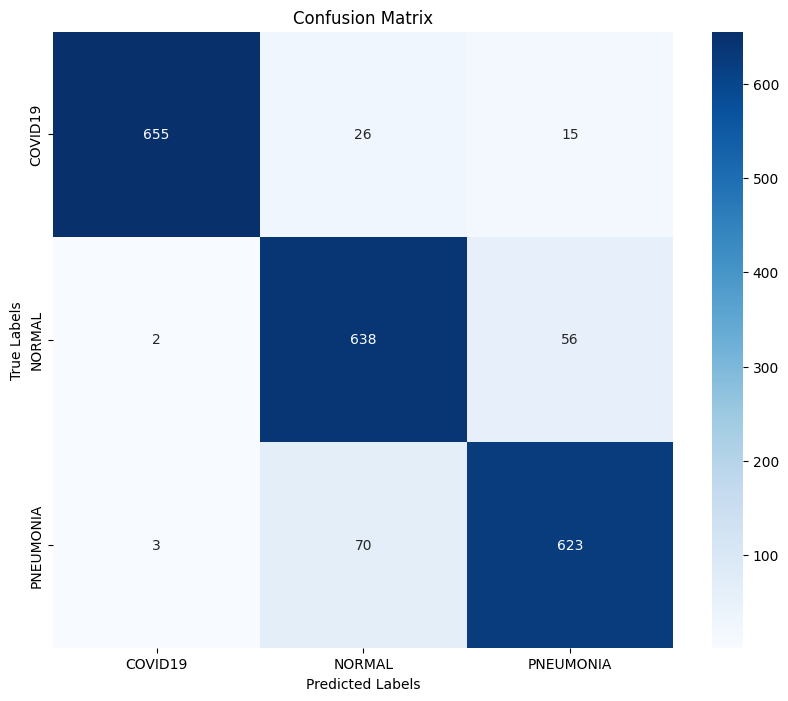

In [8]:
# Load the best model
model = load_model('/content/drive/My Drive/best_model_1.h5')

# Evaluate on Test Set
Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()